# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/file/d/1pu-e33ncuchpd1rFTuKOKnObtRpPQ8Bs/view?usp=sharing

In [93]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [94]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [95]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/tmp/ipython-input-95-1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [96]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [97]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [98]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [99]:
np.sum(subdf["caploss"])

np.int64(2842700)

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [100]:
print("Statistics for continuous features:")

continuous_cols = ["age", "yredu", "capgain", "caploss", "workhr"]
for col in continuous_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()

    print(f"{col}:")
    print(f"  Minimum: {min_val}")
    print(f"  Maximum: {max_val}")
    print(f"  Average: {mean_val:.2f}")
    print()

df[continuous_cols] = (df[continuous_cols] - df[continuous_cols].min()) / (df[continuous_cols].max() - df[continuous_cols].min())
df[:3]

Statistics for continuous features:
age:
  Minimum: 17
  Maximum: 90
  Average: 38.58

yredu:
  Minimum: 1
  Maximum: 16
  Average: 10.08

capgain:
  Minimum: 0
  Maximum: 99999
  Average: 1077.65

caploss:
  Minimum: 0
  Maximum: 4356
  Average: 87.30

workhr:
  Minimum: 1
  Maximum: 99
  Average: 40.44



,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [101]:
# hint: you can do something like this in pandas
#sum(df["sex"] == " Male")

male_data = df[df["sex"] == " Male"]
female_data = df[df["sex"] == " Female"]
sum = len(df)

male_percentage = (len(male_data) / sum) * 100
female_percentage = (len(female_data) / sum) * 100

print(f"Male percentage: {male_percentage:.2f}%")
print(f"Female percentage: {female_percentage:.2f}%")


Male percentage: 66.92%
Female percentage: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [102]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [103]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [104]:
num_records_with_missing = len(df_with_missing)
total_records = len(df)

percentage_removed = (num_records_with_missing / total_records) * 100

print(f"Percentage of records removed: {percentage_removed:.2f}%")

Percentage of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [105]:
work_values = set(df_not_missing["work"])
print(work_values)

{' Self-emp-inc', ' Without-pay', ' Federal-gov', ' Private', ' Self-emp-not-inc', ' Local-gov', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [106]:
data = pd.get_dummies(df_not_missing)

In [107]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [108]:
columns = len(data.columns)
print(f"Number of columns: {columns}")

#the number comes from the continuous featers plus the one-hot encoded categorical features

Number of columns: 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [109]:
datanp = data.values.astype(np.float32)

In [110]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

    max_index = np.argmax(onehot)
    return cat_values[feature][max_index]


In [111]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [112]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

np.random.shuffle(datanp)

train_sz = int(datanp.shape[0] * 0.7)
val_sz = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_sz]
val_set = datanp[train_sz:val_sz]
test_set = datanp[val_sz:]

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 21502
Validation set size: 4608
Test set size: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [113]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40, 25),  # compress
            nn.ReLU(),
            nn.Linear(25, 15) # bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 25),
            nn.ReLU(),
            nn.Linear(25, 40),
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.Sigmoid() # output range b/w (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**Answer**

The sigmoid activation is used because the input data has been normalized to values between 0 and 1 and so it makes sure the decoder's output is also constrained to the range between 0 and 1, making it compatible with the normalized input data and preventing the model from producing values outside this expected range.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [128]:
import torch.nn as nn
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop with loss and accuracy tracking """
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        num_batches = 0

        for data in train_loader:
            #zero out one random categorical feature
            datam = zero_out_random_feature(data.clone())
            #forward pass
            recon = model(datam)
            loss = criterion(recon, data)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            num_batches += 1

        #calculate average training loss
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)

        #calculate training accuracy
        model.eval()
        train_acc = get_accuracy(model, train_loader)
        train_accuracies.append(train_acc)

        #validation phase
        valid_loss = 0
        num_valid_batches = 0
        with torch.no_grad():
            for data in valid_loader:
                datam = zero_out_random_feature(data.clone())
                recon = model(datam)
                loss = criterion(recon, data)
                valid_loss += loss.item()
                num_valid_batches += 1

        #calculate average validation loss
        avg_valid_loss = valid_loss / num_valid_batches
        valid_losses.append(avg_valid_loss)

        #calculate validation accuracy
        valid_acc = get_accuracy(model, valid_loader)
        valid_accuracies.append(valid_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.6f}, Train Acc: {train_acc:.4f}')
        print(f'Valid Loss: {avg_valid_loss:.6f}, Valid Acc: {valid_acc:.4f}')

    epochs = range(1, num_epochs + 1)

    #plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    #plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, valid_losses, train_accuracies, valid_accuracies

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [115]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch [1/30]
Train Loss: 0.199717, Train Acc: 0.3889
Valid Loss: 0.094495, Valid Acc: 0.3886
Epoch [2/30]
Train Loss: 0.075154, Train Acc: 0.4591
Valid Loss: 0.071362, Valid Acc: 0.4580
Epoch [3/30]
Train Loss: 0.070861, Train Acc: 0.4611
Valid Loss: 0.070494, Valid Acc: 0.4605
Epoch [4/30]
Train Loss: 0.070119, Train Acc: 0.4609
Valid Loss: 0.069711, Valid Acc: 0.4602
Epoch [5/30]
Train Loss: 0.068982, Train Acc: 0.4681
Valid Loss: 0.067688, Valid Acc: 0.4661
Epoch [6/30]
Train Loss: 0.063117, Train Acc: 0.5262
Valid Loss: 0.057761, Valid Acc: 0.5265
Epoch [7/30]
Train Loss: 0.056183, Train Acc: 0.5491
Valid Loss: 0.055001, Valid Acc: 0.5492
Epoch [8/30]
Train Loss: 0.054652, Train Acc: 0.5644
Valid Loss: 0.053855, Valid Acc: 0.5644
Epoch [9/30]
Train Loss: 0.053382, Train Acc: 0.5666
Valid Loss: 0.052780, Valid Acc: 0.5666
Epoch [10/30]
Train Loss: 0.052570, Train Acc: 0.5708
Valid Loss: 0.051890, Valid Acc: 0.5706
Epoch [11/30]
Train Loss: 0.051505, Train Acc: 0.5721
Valid Loss: 0.0

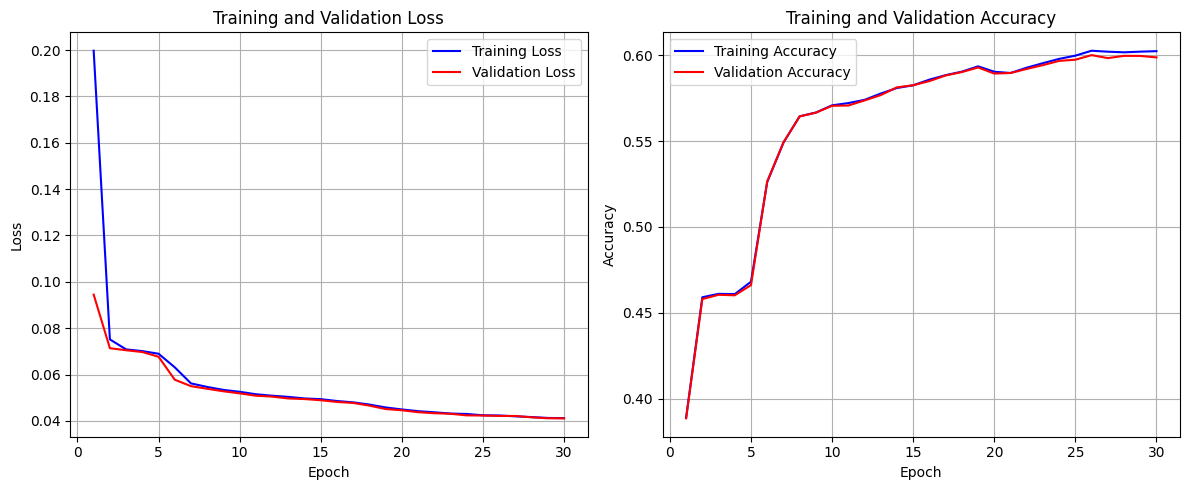

In [116]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

baseline = AutoEncoder()
train(baseline, train_loader, val_loader, num_epochs=30, learning_rate=0.0001);

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

Epoch [1/40]
Train Loss: 0.072048, Train Acc: 0.5756
Valid Loss: 0.049369, Valid Acc: 0.5758
Epoch [2/40]
Train Loss: 0.041932, Train Acc: 0.5978
Valid Loss: 0.038095, Valid Acc: 0.5938
Epoch [3/40]
Train Loss: 0.035868, Train Acc: 0.6042
Valid Loss: 0.033603, Valid Acc: 0.6004
Epoch [4/40]
Train Loss: 0.031961, Train Acc: 0.6043
Valid Loss: 0.030772, Valid Acc: 0.6037
Epoch [5/40]
Train Loss: 0.029822, Train Acc: 0.6067
Valid Loss: 0.028939, Valid Acc: 0.6066
Epoch [6/40]
Train Loss: 0.027879, Train Acc: 0.6025
Valid Loss: 0.027804, Valid Acc: 0.6005
Epoch [7/40]
Train Loss: 0.026198, Train Acc: 0.6126
Valid Loss: 0.025944, Valid Acc: 0.6114
Epoch [8/40]
Train Loss: 0.024837, Train Acc: 0.6140
Valid Loss: 0.024254, Valid Acc: 0.6095
Epoch [9/40]
Train Loss: 0.023629, Train Acc: 0.6199
Valid Loss: 0.023558, Valid Acc: 0.6175
Epoch [10/40]
Train Loss: 0.022667, Train Acc: 0.6277
Valid Loss: 0.022812, Valid Acc: 0.6230
Epoch [11/40]
Train Loss: 0.021954, Train Acc: 0.6286
Valid Loss: 0.0

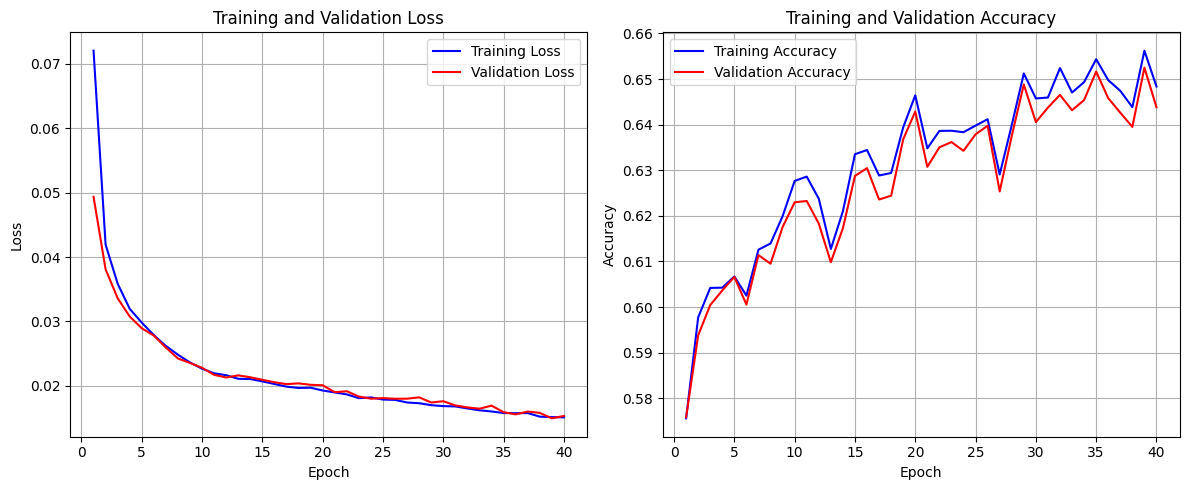

In [117]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

testModels = AutoEncoder()
train(testModels, train_loader, val_loader, num_epochs=40, learning_rate=0.001);



### **Model 1**



*   Learning rate = 0.01
*   Number of epoch = 30
* Batch size = 64


For this model, I randomly decided to change the learning rate to a higher value to see if it would improve or not. Luckily, the higher learning rate led to faster convergence, with training loss dropping more quickly in early epochs compared to the baseline. In addition, I think accuracy improved slightly, reaching higher values (around 0.63), but there was a larger gap between training and validation, suggesting potential overfitting.

The increased learning rate improved performance but introduced a small overfitting issue. The batch size of 64 seemed alright, so I will keep it constant for the next model. To help fix the overfitting, I decided to try a larger batch size to stabilize gradients and reduce overfitting, while keeping the higher learning rate to maintain faster convergence.

### **Model 2**


*   Learning rate = 0.01
*   Number of epoch = 30
* Batch size: 128

I think that the larger batch size smoothed the gradients, reducing the gap between training and validation loss compared to Model 1, indicating better generalization and less overfitting (the gaps are closer now). However, the accuracy didn't reach as high as it did in Model 1 (for this model it was around 6.25)

The larger batch size improved generalization but slightly reduced accuracy, so a batch size of 64 might be more effective for this dataset. I kept the same learning rate since it seems to be working well.
To improve accuracy, I think that training for more epochs could allow the model to balance its weights.

### **Model 3**


*   Learning rate = 0.01
*   Number of epoch = 50
* Batch size: 64

The loss shown in this model was similar to model 2. Accuracy improved a lot compared to the other models reaching around 0.64, but the gap between training and validation widened a little compared to the model before, suggesting that the model might be overfitting with the longer training.


The additional epochs improved performance, but the slight overfitting shows that a very high number of epochs might not be ideal.
For the final model, I changed it to a smaller batch size to help improve accuracy, while keeping the learning rate the same and reducing epochs to 40 to balance training time and performance.

### **Model 4**


*   Learning rate = 0.01
*   Number of epoch = 40
* Batch size: 32

The training loss reached the lowest value with these parameters and was probably the best out of all of the models, but on the other hand, the distance between training and validation accuracy widened a lot compared to the other models.

In conclusion, I think model 2 showed the best results with the loss and accuracy the most balanced

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

Epoch [1/30]
Train Loss: 0.110676, Train Acc: 0.4591
Valid Loss: 0.070237, Valid Acc: 0.4580
Epoch [2/30]
Train Loss: 0.066219, Train Acc: 0.5320
Valid Loss: 0.057099, Valid Acc: 0.5331
Epoch [3/30]
Train Loss: 0.054818, Train Acc: 0.5641
Valid Loss: 0.052129, Valid Acc: 0.5623
Epoch [4/30]
Train Loss: 0.050972, Train Acc: 0.5695
Valid Loss: 0.048893, Valid Acc: 0.5678
Epoch [5/30]
Train Loss: 0.045832, Train Acc: 0.5841
Valid Loss: 0.042544, Valid Acc: 0.5798
Epoch [6/30]
Train Loss: 0.041051, Train Acc: 0.5941
Valid Loss: 0.040076, Valid Acc: 0.5905
Epoch [7/30]
Train Loss: 0.038936, Train Acc: 0.5961
Valid Loss: 0.037899, Valid Acc: 0.5921
Epoch [8/30]
Train Loss: 0.036680, Train Acc: 0.5989
Valid Loss: 0.035594, Valid Acc: 0.5934
Epoch [9/30]
Train Loss: 0.034622, Train Acc: 0.6069
Valid Loss: 0.034526, Valid Acc: 0.6029
Epoch [10/30]
Train Loss: 0.033432, Train Acc: 0.6011
Valid Loss: 0.033585, Valid Acc: 0.5969
Epoch [11/30]
Train Loss: 0.032297, Train Acc: 0.6035
Valid Loss: 0.0

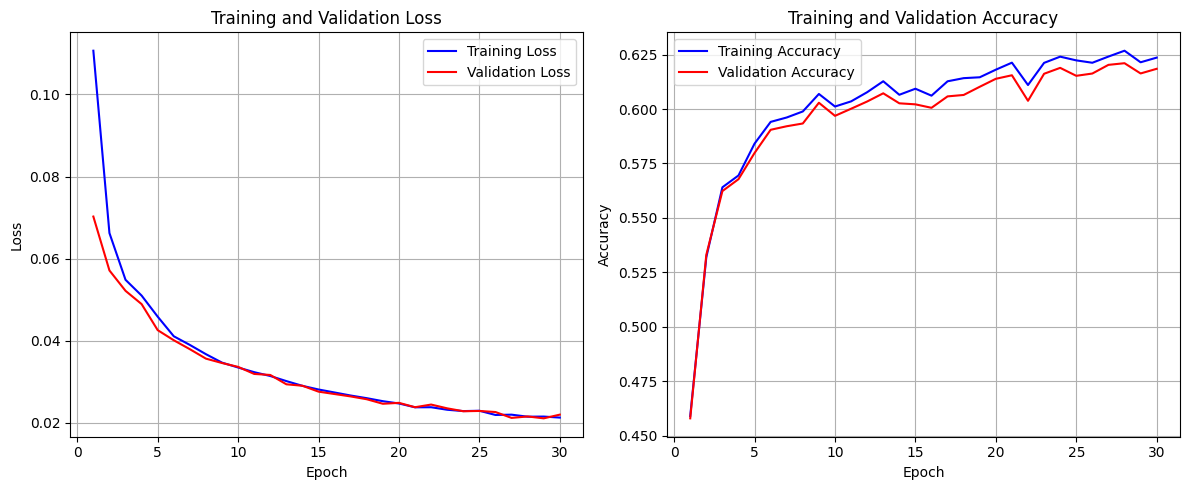

Test Accuracy: 0.6217


In [118]:
#for model 2 with the best hyperparameter tuning
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder = AutoEncoder()
train(autoencoder, train_loader, val_loader, num_epochs=30, learning_rate=0.001);

autoencoder.eval()
test_accuracy = get_accuracy(autoencoder, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [119]:
#get most common values for each feature
train_data = train_set
most_common = {}
for feature in catcols:
    start_idx = cat_index[feature]
    stop_idx = start_idx + len(cat_values[feature])
    feature_sums = np.sum(train_data[:, start_idx:stop_idx], axis=0)
    most_common_idx = np.argmax(feature_sums)
    most_common[feature] = cat_values[feature][most_common_idx]

#compute accuracy
correct = 0.0
test_data = test_set
for record in test_data:
    for feature in catcols:
        if most_common[feature] == get_feature(record, feature):
            correct += 1

accuracy = correct / (len(test_set) * len(catcols))
print(f"The baseline test accuracy is {round(accuracy * 100, 2)}%")

The baseline test accuracy is 45.69%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**Answer**

My test accuracy in part a was 62.17% compared with the baseline accuracy of 45.69%.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [120]:
#look at first item
test_data = test_set
first_record = test_data[0]

feature_values = {}
for feature in catcols:
    feature_values[feature] = get_feature(first_record, feature)

print("First test record features:", feature_values)

First test record features: {'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


**Answer**

No, I don't think you could guess the person's education level just based on the other features because you do not know much about the person's life or what path he chose to take. You could probably guess based on the occupation but you wouldn't know for sure.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [124]:
test_edu = zero_out_feature(test_data[:1], "edu")[0]
predict = autoencoder(torch.from_numpy(test_edu))
get_feature(predict.detach().numpy(), "edu")

'Bachelors'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [126]:
predicted_edu_baseline = most_common['edu']
print(f"Baseline's prediction: {predicted_edu_baseline}")

Baseline's prediction: HS-grad


In [127]:
%%shell
jupyter nbconvert --to html /content/Lab4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 673847 bytes to /content/Lab4_Data_Imputation.html
